# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

Import Libraries

In [12]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from ht_sim_neu import sim1d


Define the constants and initial conditions

Material :- AL 380

| Sr.No | Properties  | Symbol | Value  | Unit |Range(source) |
|:---:|:---:|:---:|:---:|:---:|:--:|
| 1  | Liquidus Density | $\rho_{l}$  | 2300 | $kg/m^3$  |  2200-2400 (ASM handbook) |
|  2 |  Solidus Density  |  $\rho_{s}$  | 2500  |  $kg/m^3$  | 2400-2600 (ASM handbook) |
|  3 |  Mushy Desnity |  $\rho_{m}$  |  2400 | $kg/m^3$   |Increase linearly from liquid to solid (ASM handbook) |
|  4 |  Liquidus Thermal Conductivity| $k_l$  |  70 | $W/m-K$  |60-80 (ASM handbook) |
|  5 |  Solidus Thermal Conductivity | $k_s$  | 180  |  $W/m-K$ | 150-210(ASM handbook) |
|  6 | Mushy Zone Thermal Conductivity | $k_m$  | 125  |  $W/m-K$ |Decrease linearly from liquid to solid (ASM handbook) |
|  7 | Liquidus Specific Heat | $c_{pl}$  | 1190  | $J/kg-K$  | 1100 -1200 (ASM handbook)|
|  8 | Solidus Specific Heat | $c_{ps}$  |  1100 |  $J/kg-K$  | 1100-1200 (ASM handbook)|
|  9 | Mushy Zone Specific Heat |  $c_{pm}$ | 1175 | $J/kg-K$   |decrease lineraly from liquid to solid (ASM handbook)|
|  10 | Latent Heat of Fusion | $L_{fusion}$  | 450e3  | $J/kg$ | (400-500)e3 (ASM handbook) |
| 11 | Left Boundary Temperature |$BCT_{l}$|623 |$K$| (623-723) Nissan Data |
|12 | Right Boundary Temperature | $BCT_{r}$|623 |$K$| (623-723) Nissan Data |
|13| Freezing time | |60 |sec|||

In [13]:
# Geometry
length = 15.0e-3             # Length of the rod

# Material properties
rho = 2300.0                     # Density of AL380 (kg/m^3)
rho_l = 2460.0                   # Density of AL380 (kg/m^3)
rho_s = 2710.0                    # Density of AL380 (kg/m^3)
rho_m = (rho_l + rho_s )/2       # Desnity in mushy zone is taken as average of liquid and solid density

k = 104.0                       # W/m-K
k_l = k                       # W/m-K
k_s = 96.2                    # W/m-K
k_m =  (k_l+k_s)/2                     # W/m-K
k_mo = 41.5


cp = 1245.3                      # Specific heat of aluminum (J/kg-K)
cp_l = cp                      # Specific heat of aluminum (J/kg-K)
cp_s = 963.0                 # Specific heat of aluminum (J/kg-K)
cp_m =  (cp_l+cp_s)/2                 # Specific heat of mushy zone is taken as average of liquid and solid specific heat
# cp_m = cp
           # Thermal diffusivity
alpha_l = k_l / (rho_l * cp_l) 
alpha_s = k_s / (rho_s*cp_s)
alpha_m = k_m / (rho_m * cp_m)          #`Thermal diffusivity in mushy zone is taken as average of liquid and solid thermal diffusivity`


#L_fusion = 3.9e3                 # J/kg
L_fusion = 389.0e3               # J/kg  # Latent heat of fusion of aluminum
         # Thermal diffusivity


T_L = 574.4 +273.0                       #  K -Liquidus Temperature (615 c) AL 380
T_S = 497.3 +273.0                     # K- Solidus Temperature (550 C)
m_eff =(k_m/(rho_m*(cp_m + (L_fusion/(T_L-T_S)))))
print (f"alpha_l = {alpha_l}, alpha_s = {alpha_s}, m_eff = {m_eff}")

# htc = 10.0                   # W/m^2-K
# q = htc*(919.0-723.0)
# q = 10000.0


num_points = 50                        # Number of spatial points
dx = length / (num_points - 1)         # Distance between two spatial points
print('dx is',dx)

                                                              
# Time Discretization  
# 
time_end = 60        # seconds                         

maxi = max(alpha_s,alpha_l,alpha_m)
dt = abs(0.5*((dx**2) /maxi)) 

print('dt is ',dt)
num_steps = round(time_end/dt)
print('num_steps is',num_steps)
cfl = 0.5 *(dx**2/max(alpha_l,alpha_s,alpha_m))
print('cfl is',cfl)

time_steps = np.linspace(0, time_end, num_steps + 1)
step_coeff = dt / (dx ** 2)

if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('stability criteria not satisfied')
    sys.exit()

alpha_l = 3.394878564540885e-05, alpha_s = 3.686205086349929e-05, m_eff = 6.296953764744878e-06
dx is 0.0003061224489795918
dt is  0.0012711033647622566
num_steps is 47203
cfl is 0.0012711033647622566
stability criteria satisfied


### Initial and Boundary Conditions

In [14]:


# Initial temperature and phase fields
temperature = np.full(num_points+2, 919.0)            # Initial temperature of the rod with ghost points at both ends
phase = np.zeros(num_points+2)*0.0                    # Initial phase of the rod with ghost points at both ends

# Set boundary conditions
# temperature[-1] = 919.0 
phase[-1] = 1.0

# temperature[0] = 919.0 #(40 C)
phase[0] = 1.0

# Store initial state in history
temperature_history = [temperature.copy()]    # List to store temperature at each time step
phi_history = [phase.copy()]                    # List to store phase at each time step
temp_init = temperature.copy()                 # Initial temperature of the rod
# print(temperature_history,phi_history)
# Array to store temperature at midpoint over time
midpoint_index = num_points // 2                          # Index of the midpoint

midpoint_temperature_history = [temperature[midpoint_index]]            # List to store temperature at midpoint over time
dm = 60.0e-3                                                            # die thickness in m

# r_m =  (k_mo / dm) + (1/htc)

t_surr = 500.0                                        # Surrounding temperature in K
# t_surr = h()

def kramp(temp,v1,v2,T_L,T_s):                                      # Function to calculate thermal conductivity in Mushy Zone
        slope = (v1-v2)/(T_L-T_S)
        if temp > T_L:
            k_m = k_l
        elif temp < T_S:
            k_m = k_s
        else:
            k_m = k_s + slope*(temp-T_S)
        return k_m

def cp_ramp(temp,v1,v2,T_L,T_s):                                    # Function to calculate specific heat capacity in Mushy Zone
    slope = (v1-v2)/(T_L-T_S)
    if temp > T_L:
        cp_m = cp_l
    elif temp < T_S:
        cp_m = cp_s
    else:
        cp_m = cp_s + slope*(temp-T_S)
    return cp_m

def rho_ramp(temp,v1,v2,T_L,T_s):                                       # Function to calculate density in Mushy Zone
    slope = (v1-v2)/(T_L-T_S)
    if temp > T_L:
        rho_m = rho_l
    elif temp < T_S:
        rho_m = rho_s
    else:
        rho_m = rho_s + slope*(temp-T_S)
    return rho_m

Solving the heat transfer equation and phase change using numerical methods

In [15]:

for m in range(1, num_steps+1):                                                                            # time loop
    htc = 10.0                   # htc of Still air in W/m^2-K
    q1 = htc*(temp_init[0]-t_surr)   # Heat flux at the left boundary
    
    # print(f"q1 is {q1}")
    temperature[0] = temp_init[0] + alpha_l * step_coeff * ((2.0*temp_init[1]) - (2.0 * temp_init[0])-(2.0*dx*(q1)))  # Update boundary condition temperature
    
    q2 = htc*(temp_init[-1]-t_surr)                   # Heat flux at the right boundary
    temperature[-1] = temp_init[-1] + alpha_l * step_coeff * ((2.0*temp_init[-2]) - (2.0 * temp_init[-1])-(2.0*dx*(q2)))  # Update boundary condition temperature
    
    for n in range(1,num_points+1):              # space loop, adjusted range
       
        if temperature[n] >= T_L:
            temperature[n] += ((alpha_l * step_coeff) * (temp_init[n+1] - (2.0 * temp_init[n]) + temp_init[n-1]))
            phase[n] = 0
            
            # print(f" Time-Step{m},Spatial point{n},Temperature{temperature[n]}")
        elif T_S < temperature[n] < T_L:
            
            k_m = kramp(temperature[n],k_l,k_s,T_L,T_S)
            cp_m = cp_ramp(temperature[n],cp_l,cp_s,T_L,T_S)
            rho_m = rho_ramp(temperature[n],rho_l,rho_s,T_L,T_S)
            m_eff =(k_m/(rho_m*(cp_m + (L_fusion/(T_L-T_S)))))
            
            temperature[n] += ((m_eff * step_coeff)* (temp_init[n+1] - (2.0 * temp_init[n]) + temp_init[n-1]))
            
            phase[n] = (T_L - temperature[n]) / (T_L - T_S)
            # print(m,n,temperature[n],phase[n])
         
        elif temperature[n]<T_S:
            temperature[n] += ((alpha_s * step_coeff) * (temp_init[n+1] - (2.0 * temp_init[n])+ temp_init[n-1]))
            phase[n] = 1
                     
        else:
            print("ERROR: should not be here")

     
          
    temperature = temperature.copy()                                                                # Update temperature
    phase = phase.copy()                                                                            # Update phase
    temp_init = temperature.copy()                                                                  # Update last time step temperature
    temperature_history.append(temperature.copy())                                                  # Append the temperature history to add ghost points
    phi_history.append(phase.copy())                                                                # Append the phase history to add ghost points
    midpoint_temperature_history.append(temperature[midpoint_index])                                # Store midpoint temperature
    
    
    # print(f"Step {m}, Temperature: {temperature}")
    


# print(midpoint_temperature_history)
#print(phi_history)





[[919.         919.         919.         ... 919.         919.
  919.        ]
 [917.81871701 919.         919.         ... 919.         919.
  917.81871701]
 [917.72868875 918.45603782 919.         ... 919.         918.45603782
  917.72868875]
 ...
 [587.31639511 587.5781532  587.82968191 ... 587.82968191 587.5781532
  587.31639511]
 [587.31129571 587.57303851 587.82455253 ... 587.82455253 587.57303851
  587.31129571]
 [587.30619661 587.56792412 587.81942345 ... 587.81942345 587.56792412
  587.30619661]]


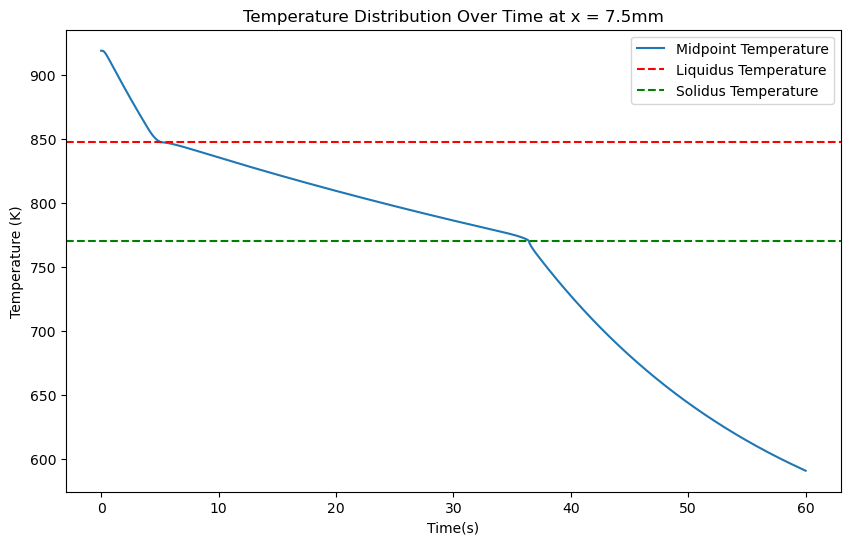

In [16]:
# Plot temperature history for debugging
temperature_history_1 = np.array(temperature_history)
print(temperature_history_1)
time_ss= np.linspace(0, time_end, num_steps+1)
# print(time_ss.shape)
plt.figure(figsize=(10, 6))
plt.plot(time_ss, midpoint_temperature_history, label='Midpoint Temperature')
plt.axhline(y=T_L, color='r', linestyle='--', label='Liquidus Temperature')
plt.axhline(y=T_S, color='g', linestyle='--', label='Solidus Temperature')
plt.xlabel('Time(s)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Distribution Over Time at x = 7.5mm') 
plt.legend()
plt.show()

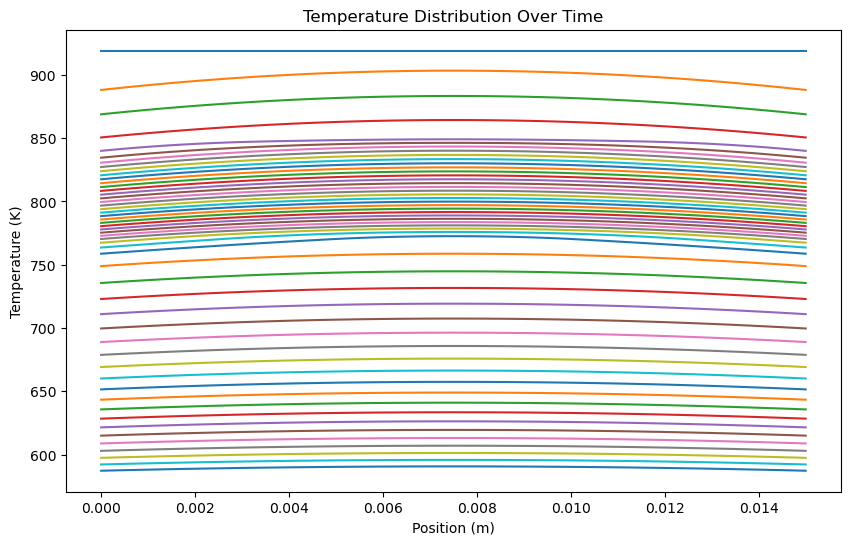

In [17]:
# Plot temperature history for debugging
plt.figure(figsize=(10, 6))
for i in range(0, num_steps, num_steps // 50):
    plt.plot(np.linspace(0, length, num_points+2), temperature_history[i], label=f't={i * dt:.2f} s')

plt.xlabel('Position (m)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Distribution Over Time')
# plt.legend()
plt.show()

In [18]:
temperature_history = np.array(temperature_history)
phi_history = np.array(phi_history)
# print(temperature_history.shape)
# print(phi_history)

In [19]:
# Niyama Calcualtion


# Gradient Calculation

grad_t_x = np.absolute(np.gradient(temperature_history, dx, axis=1))
print(grad_t_x[100,:])
grad_t_t = np.absolute(np.gradient(temperature_history,dt,axis=0))
# print(grad_t_t[100,:])

Ny = np.divide(grad_t_x, grad_t_t, out=np.zeros_like(grad_t_x, dtype=float), where=grad_t_t!=0)
# print(Ny)

C_lambda = 40.0e-06
del_Pcr = 1.01e5
dyn_visc = 1.2e-3
beta = (rho_s - rho_l)/ rho_l
# print(beta)
del_Tf = T_L - T_S
# print(del_Tf)
k1a=(dyn_visc*beta*del_Tf)
k1 = (del_Pcr/k1a)**(1/2)
# print(k1)


# k2 = np.divide(grad_t_x, grad_t_t_power, out=np.zeros_like(grad_t_x, dtype=float), where=grad_t_t_power!=0)
k2 = np.zeros((num_steps+1,num_points+2))
for i in range(num_steps+1):
    for j in range(num_points+2):
        if grad_t_x[i,j] == 0:
            k2[i,j] = 0
        if grad_t_t[i,j]== 0:
            k2[i,j] = 0
        else:
            k2[i,j] = ((grad_t_x[i,j]))/ ((grad_t_t[i,j]))**(5/6)
    
# k2 = grad_t_x/((grad_t_t)**(5/6))
# print(k2)
Dim_ny = C_lambda * k1 * k2
print(Dim_ny)

# print(grad_t_t[:, 50])
# plot = plt.figure(figsize=(10, 6))
# plt.plot(time_ss, grad_t_x[:, 50], label='Niyama Number at x = 7.5mm')
# plt.xlabel('Time(s)')
# plt.ylabel('Niyama Number')
# plt.title('Niyama Number Distribution Over Time at x = 7.5mm')
# plt.legend()
# plt.show()**

[3926.06834787 3758.98759202 3427.08263246 3101.44701133 2785.45753706
 2482.17325065 2194.25162625 1923.8848173  1672.75827526 1442.03254132
 1232.34756708 1043.84754302  876.22314344  728.76725014  600.43978887
  489.93714519  395.76185515  316.28868192  249.8238815   194.65520817
  149.09108145  111.48813768   80.26719054   53.91828027   30.99608261
   10.10737661   10.10737661   30.99608261   53.91828027   80.26719054
  111.48813768  149.09108145  194.65520817  249.8238815   316.28868192
  395.76185515  489.93714519  600.43978887  728.76725014  876.22314344
 1043.84754302 1232.34756708 1442.03254132 1672.75827526 1923.8848173
 2194.25162625 2482.17325065 2785.45753706 3101.44701133 3427.08263246
 3758.98759202 3926.06834787]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 2.85008842  2.89110806  0.         ...  0.          2.89110806
   2.85008842]
 [ 3.29071303  2.75888893  2.54058336 ...  2.54058336  2.75888893
   3.29071303]
 ...
 [35.22190565 34.4476

Plot the Results

Transposed Temperature History Shape: (47204, 52)
Transposed Phi History Shape: (47204, 52)


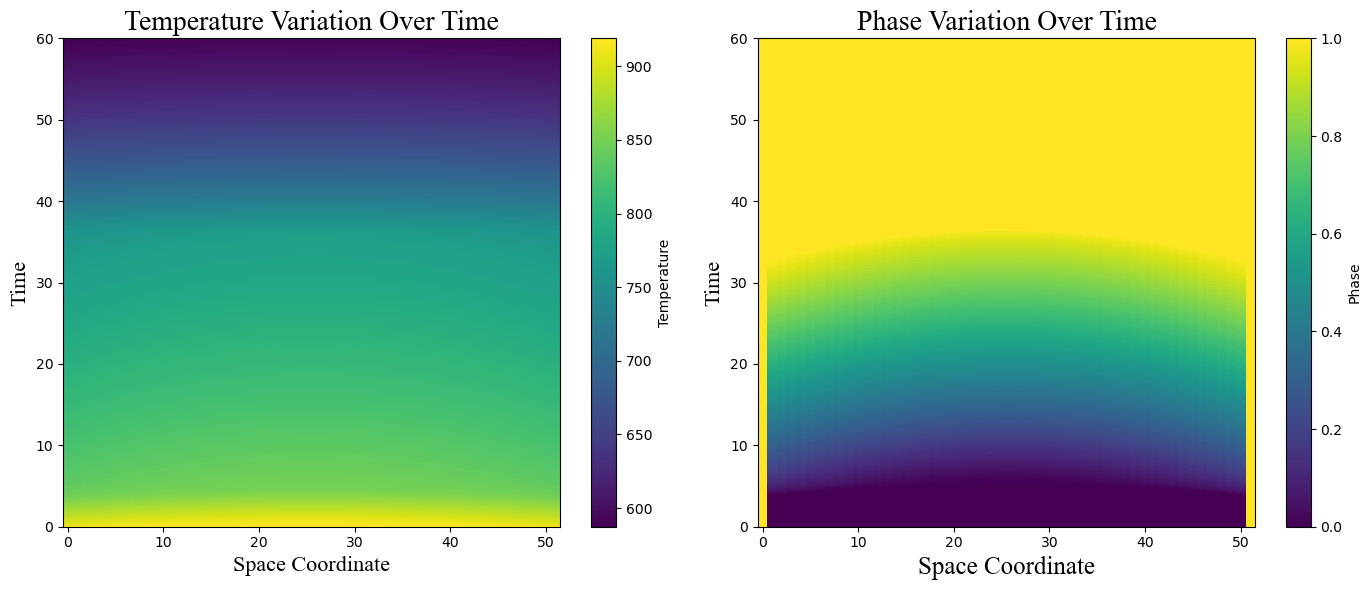

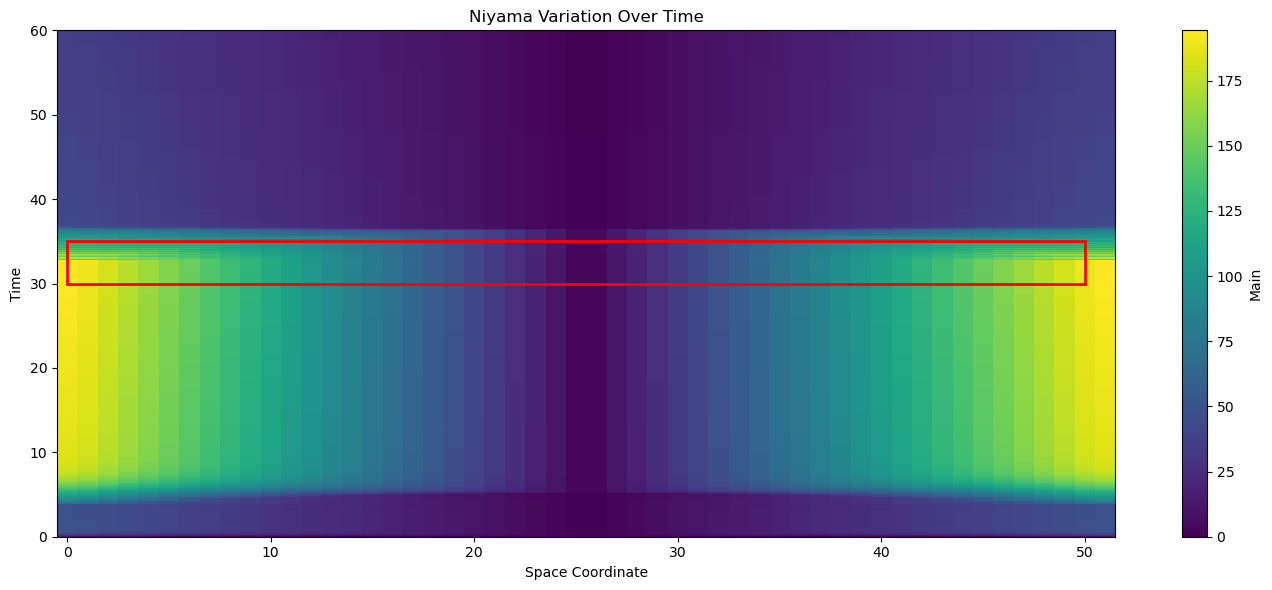

In [28]:
# Assuming you have temperature_history and phi_history as lists of arrays
temperature_history = np.array(temperature_history)
phi_history = np.array(phi_history)



# Check the new shape after transposing
print("Transposed Temperature History Shape:", temperature_history.shape)
print("Transposed Phi History Shape:", phi_history.shape)

# Create a meshgrid for space and time coordinates
space_coord, time_coord = np.meshgrid(np.arange(temperature_history.shape[1]), np.arange(temperature_history.shape[0]))

time_coord = time_coord * dt 
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the temperature history on the left subplot
im1 = ax1.pcolormesh(space_coord, time_coord, temperature_history, cmap='viridis')
ax1.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax1.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax1.set_title('Temperature Variation Over Time',fontname='Times New Roman', fontsize=20)
fig.colorbar(im1, ax=ax1, label='Temperature')

# Plot the phase history on the right subplot
im2 = ax2.pcolormesh(space_coord, time_coord, phi_history, cmap='viridis')
ax2.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=18)
ax2.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax2.set_title('Phase Variation Over Time',fontname='Times New Roman', fontsize=20)
fig.colorbar(im2, ax=ax2, label='Phase')
plt.tight_layout()
plt.show()

#plot the main
fig, ax = plt.subplots(figsize=(14, 6))
im = ax.pcolormesh(space_coord, time_coord, Dim_ny, cmap='viridis')
ax.set_xlabel('Space Coordinate')
ax.set_ylabel('Time')
ax.set_title('Niyama Variation Over Time')
fig.colorbar(im, ax=ax, label='Main')

# Define the rectangular box properties
box_x = 0      # x position of the bottom left corner
box_y = 30      # y position of the bottom left corner
box_width = 50 # width of the rectangle
box_height = 5# height of the rectangle

# Create the rectangular box
rect = patches.Rectangle((box_x, box_y), box_width, box_height, linewidth=2, edgecolor='r', facecolor='none')

# Add the rectangular box to the plot
ax.add_patch(rect)

plt.tight_layout()
plt.show()